## Analyse confidence and time for predictions

In [26]:
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from utils import *
import matplotlib.pyplot as plt
import sklearn.metrics as skm
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve, auc, confusion_matrix

## Utility functions

In [27]:
def compute_distances_to_boundary(X_test, ocsvm):
    """
    Compute the signed distances of test samples to the decision boundary of a trained One-Class SVM.

    Parameters:
        X_test (numpy.ndarray): The test samples (shape: [n_samples, n_features]).
        ocsvm (OneClassSVM): A trained One-Class SVM model.

    Returns:
        distances (numpy.ndarray): Signed distances of the test samples to the decision boundary.
    """
    # Use the decision_function method to get distances
    distances = ocsvm.decision_function(X_test).ravel()  # Flatten to 1D array
    return distances

def plot_decision_boundary(decision_function, xx, yy):
    # Step 4: Plot the Results
    plt.figure(figsize=(10, 6))
    # Contour: Decision boundary at level 0
    plt.contour(xx, yy, decision_function, levels=[0], linewidths=2, colors='black')
    # Filled Contour: Regions
    plt.contourf(xx, yy, decision_function, levels=np.linspace(decision_function.min(), 0, 10), cmap=plt.cm.PuBu)
    plt.contourf(xx, yy, decision_function, levels=np.linspace(0, decision_function.max(), 10), cmap=plt.cm.Oranges)

    # Plot training data
    # plt.scatter(X_not_distracted[:, 0], X_not_distracted[:, 1], c='blue', label='Training Data (Not Distracted)')
    # # Highlight detected "distracted" and "not distracted" samples
    # plt.scatter(X_test[:, 0], X_test[:, 1], c='white', edgecolors='k', label='Test Data')

    plt.title('One-Class SVM Decision Boundary')
    plt.xlabel('Error signal')
    plt.ylabel('U signal')
    plt.legend()
    plt.show()
    

def evaluate_anomaly_detection(X_test, y_test, decision_function):
    # Step 1: Predict decision function values for the test data
    decision_scores = decision_function(X_test)

    # Step 2: Set a threshold (default 0 for One-Class SVM)
    threshold = 0  # You can adjust this based on validation data

    # Step 3: Generate predictions based on the threshold
    y_pred = (decision_scores < threshold).astype(int)  # 1 for anomaly, 0 for normal

    # Step 4: Compute metrics
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    return f1, precision, recall


## Read signals from file

In [28]:
error_not_distracted, u_signal_not_distracted, x_signal_not_distracted = process_signals(error_file= r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRN/e.csv', u_file=r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRN/u.csv', x_file=r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRN/x.csv')
error_distracted, u_signal_distracted, x_signal_distracted         = process_signals(error_file= r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRDPE/e.csv', u_file=r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRDPE/u.csv', x_file=r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRDPE/x.csv')

person_idx = 0
tc_test = np.loadtxt(r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRDPE/mdist.csv', delimiter=',')
tc_test_col = tc_test[:, person_idx]

# combine the entire list in the priors
error_not_distracted_person = np.concatenate(error_not_distracted[person_idx])
u_not_distracted_person = np.concatenate(u_signal_not_distracted[person_idx])
x_not_distracted_person = np.concatenate(x_signal_not_distracted[person_idx])

# X_not_distracted = np.column_stack((error_not_distracted_person[:-1], u_not_distracted_person[:-1], x_not_distracted_person[:-1]))

X_not_distracted = np.column_stack((error_not_distracted_person, u_not_distracted_person))
                                                                                              
error_distracted_person = np.concatenate(error_distracted[person_idx])
u_distracted_person = np.concatenate(u_signal_distracted[person_idx])
x_distracted_person = np.concatenate(x_signal_distracted[person_idx])

# X_test = np.column_stack((error_distracted_person, u_distracted_person, x_distracted_person))
X_test = np.column_stack((error_distracted_person, u_distracted_person))

## Load trained model

In [29]:
# load the joblib file
ocsvm = joblib.load(r"/home/mihai/Thesis/Data/Models/ocsvm_model_0.joblib")

In [30]:
distances = compute_distances_to_boundary(X_test, ocsvm)

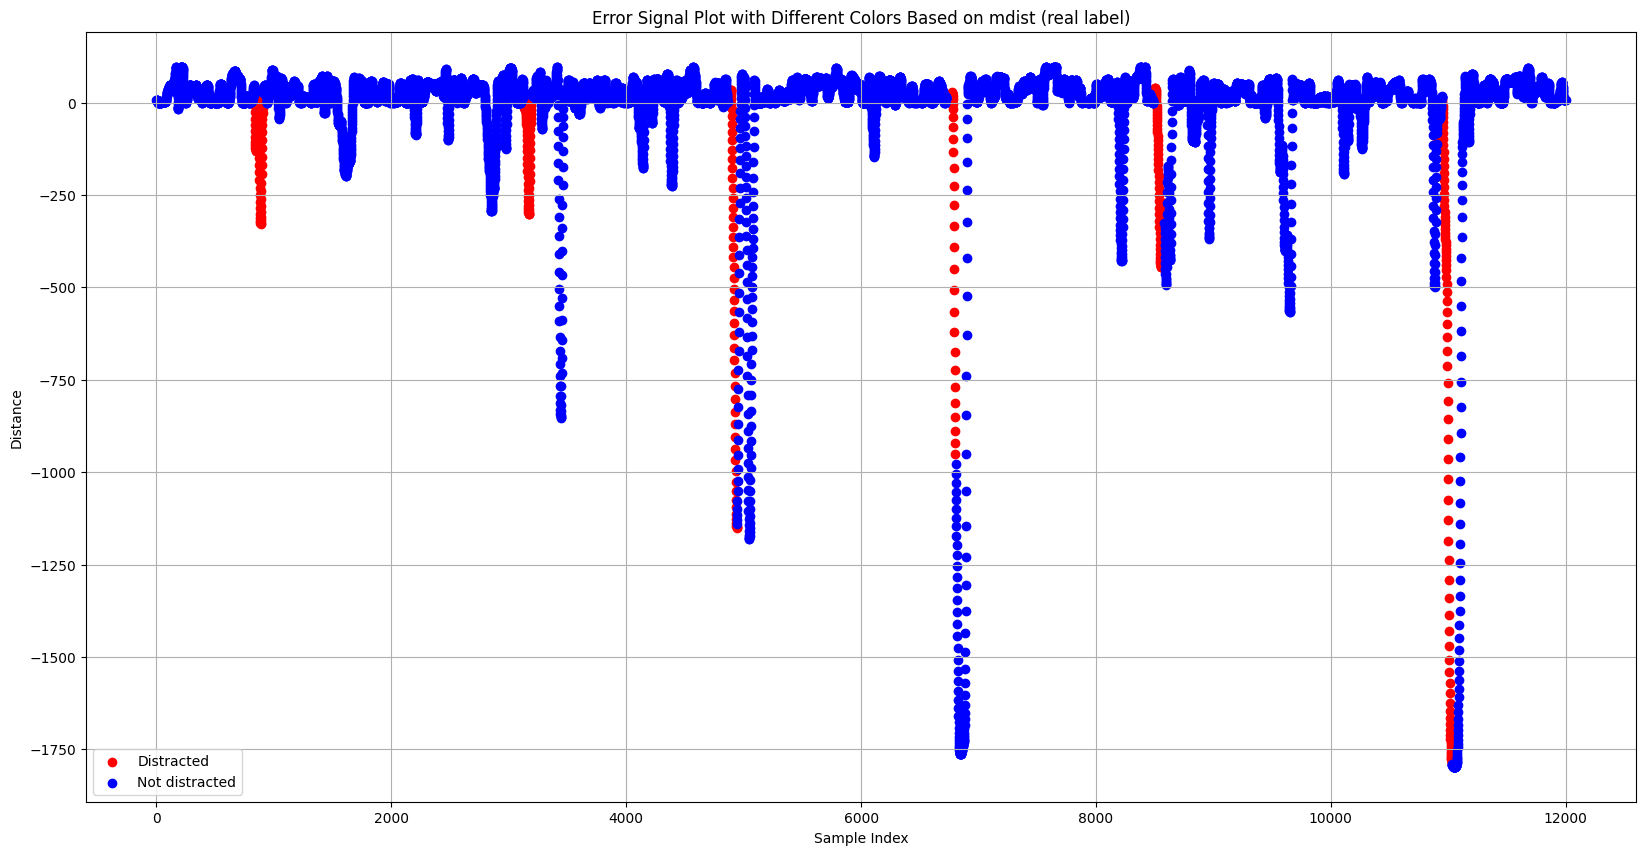

In [31]:
tc_test_col = tc_test[:, 0]
distances_run = distances[12000*0:1*12000]

# Create a mask for tc_test == 1 and tc_test == 0
mask_1 = tc_test_col == 1
mask_0 = tc_test_col == 0

# Plotting
plt.figure(figsize=(20, 10))
plt.scatter(np.arange(len(distances_run))[mask_1], distances_run[mask_1], color='red', label='Distracted')
plt.scatter(np.arange(len(distances_run))[mask_0], distances_run[mask_0], color='blue', label='Not distracted')
plt.grid()
# Add labels and title
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.title('Error Signal Plot with Different Colors Based on mdist (real label)')
plt.legend()
plt.show()

In [32]:
def trigger_ocsvm_alarm(distances, threshold=-500):
    """
    Detect when 10 consecutive samples have distances below a specified threshold and trigger an alarm.
    
    Parameters:
        distances (numpy.ndarray): Array of distances from the decision boundary (signed distances).
    
    Returns:
        alarm_indices (list): List of starting indices for alarms where the condition is met.
    """

    # Initialize variables
    alarm_indices = []
    consecutive_count = 0
    
    # Iterate through the distances
    for i in range(len(distances)):
        if distances[i] < threshold:
            consecutive_count += 1
            # If 10 consecutive samples meet the condition, trigger the alarm
            if consecutive_count == 10:
                # Record the starting index of the alarm
                alarm_indices.append(i - 9)  # Subtract 9 to get the starting index of the 10-sample sequence
        else:
            # Reset the consecutive count if condition is broken
            consecutive_count = 0
    
    return alarm_indices

In [33]:
def trigger_ocsvm_alarm_with_confidence(distances, threshold=-500):
    """
    Detect alarms based on distances below a threshold and compute confidence scores.

    Parameters:
        distances (numpy.ndarray): Array of distances from the decision boundary (signed distances).
        threshold (float): The threshold below which distances are considered anomalous.

    Returns:
        alarm_indices (list): List of starting indices for alarms where the condition is met.
        confidences (list): List of confidence scores for each alarm.
    """
    # Initialize variables
    alarm_indices = []
    confidences = []
    consecutive_count = 0
    
    # Sigmoid parameter for distance confidence
    alpha = 0.0001  # Adjust this based on the scale of distances

    # Iterate through the distances
    for i in range(len(distances)):
        if distances[i] < threshold:
            consecutive_count += 1
            # Compute distance confidence
            distance_confidence = 1 / (1 + np.exp(-alpha * (threshold - distances[i])))

            # If 10 consecutive samples meet the condition, trigger the alarm
            if consecutive_count == 10:
                # Record the starting index of the alarm
                alarm_indices.append(i - 9)  # Subtract 9 to get the starting index of the 10-sample sequence
                
                # Compute sequence confidence
                sequence_confidence = 1.0  # Fully confident when 10 consecutive samples are met
                
                # Combine confidences
                combined_confidence = distance_confidence * sequence_confidence
                confidences.append(combined_confidence)
        else:
            # Reset the consecutive count if condition is broken
            consecutive_count = 0

    return alarm_indices, confidences

# Example usage
alarm_indices, confidences = trigger_ocsvm_alarm_with_confidence(distances)
print("Alarm Indices:", alarm_indices)
print("Confidences:", confidences)


Alarm Indices: [3429, 4916, 5028, 6793, 9640, 10987, 12517, 15125, 21189, 22782, 25484, 25950, 27022, 29235, 31176, 32845, 35376, 38981, 41431, 43223]
Confidences: [0.5078516621330227, 0.507530802451896, 0.5118827402563382, 0.510517314805129, 0.5016668762110055, 0.5089155467572137, 0.5039060327328688, 0.5080197017377339, 0.5203131985586212, 0.5083772738917559, 0.5004067989891315, 0.5056719102597276, 0.5046205239863261, 0.5165061261060708, 0.5130128889052945, 0.5015330007201535, 0.5032881284773258, 0.5156395603292332, 0.5057971573101165, 0.5092942051586442]


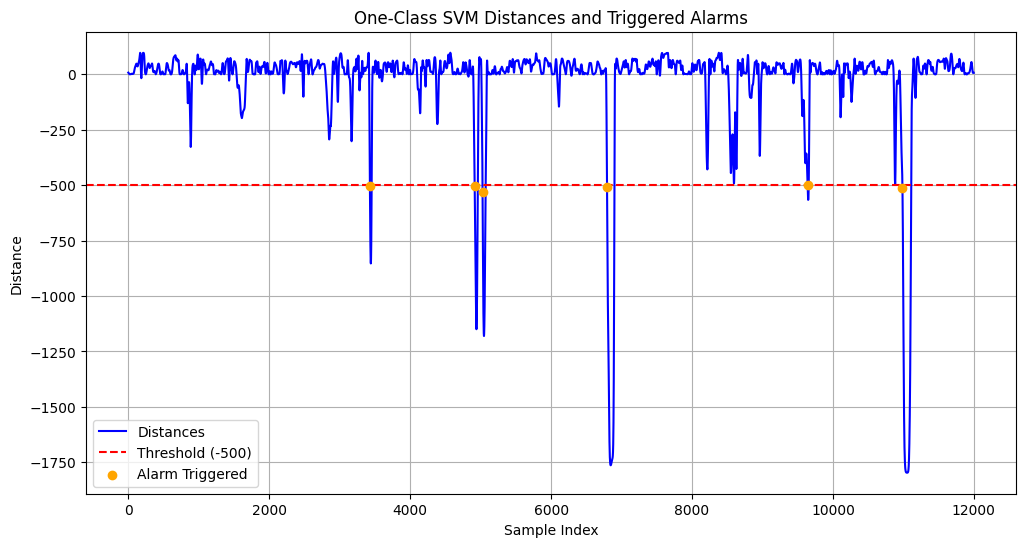

Alarm Indices: [3429, 4916, 5028, 6793, 9640, 10987]
Confidences: [0.5078516621330227, 0.507530802451896, 0.5118827402563382, 0.510517314805129, 0.5016668762110055, 0.5089155467572137]


In [34]:
def trigger_ocsvm_alarm_with_confidence(distances, threshold=-500):
    """
    Detect alarms based on distances below a threshold and compute confidence scores.

    Parameters:
        distances (numpy.ndarray): Array of distances from the decision boundary (signed distances).
        threshold (float): The threshold below which distances are considered anomalous.

    Returns:
        alarm_indices (list): List of starting indices for alarms where the condition is met.
        confidences (list): List of confidence scores for each alarm.
    """
    # Initialize variables
    alarm_indices = []
    confidences = []
    consecutive_count = 0
    
    # Sigmoid parameter for distance confidence
    alpha = 0.0001  # Adjust this based on the scale of distances

    # Iterate through the distances
    for i in range(len(distances)):
        if distances[i] < threshold:
            consecutive_count += 1
            # Compute distance confidence
            distance_confidence = 1 / (1 + np.exp(-alpha * (threshold - distances[i])))

            # If 10 consecutive samples meet the condition, trigger the alarm
            if consecutive_count == 10:
                # Record the starting index of the alarm
                alarm_indices.append(i - 9)  # Subtract 9 to get the starting index of the 10-sample sequence
                
                # Compute sequence confidence
                sequence_confidence = 1.0  # Fully confident when 10 consecutive samples are met
                
                # Combine confidences
                combined_confidence = distance_confidence * sequence_confidence
                confidences.append(combined_confidence)
        else:
            # Reset the consecutive count if condition is broken
            consecutive_count = 0

    return alarm_indices, confidences


threshold = -500

# Detect alarms and calculate confidences
alarm_indices, confidences = trigger_ocsvm_alarm_with_confidence(distances_run, threshold)

# Plot distances and alarms
plt.figure(figsize=(12, 6))
plt.plot(distances_run, label="Distances", color="blue")
plt.axhline(y=threshold, color="red", linestyle="--", label=f"Threshold ({threshold})")
plt.scatter(alarm_indices, [distances[i] for i in alarm_indices], 
            color="orange", label="Alarm Triggered", zorder=5)
plt.title("One-Class SVM Distances and Triggered Alarms")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.legend()
plt.grid()
plt.show()

# Print alarms and confidences
print("Alarm Indices:", alarm_indices)
print("Confidences:", confidences)


In [73]:
alpha = 0.01

def sigmoid(score, threshold):
        """Transform score to probability using sigmoid function."""
        return 1 - 1 / (1 + np.exp(-alpha * (score - threshold)))

print("Threshold:", threshold)
print("Alpha:   ", alpha)

normalized_scores = sigmoid(distances[:12000], threshold=-50)


Threshold: -500
Alpha:    0.01


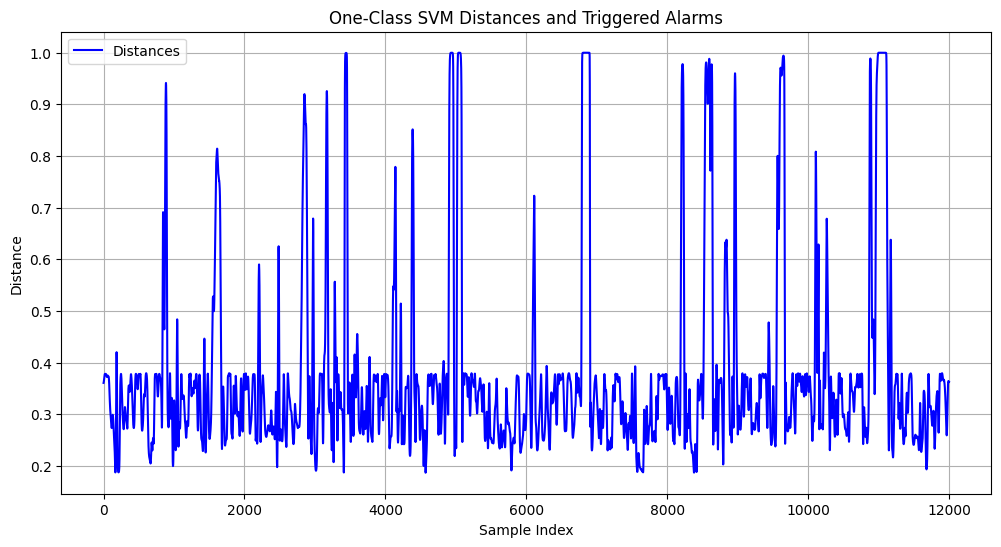

Alarm Indices: [2981, 5431, 7223]
Confidences: [0.5078516621330227, 0.507530802451896, 0.5118827402563382, 0.510517314805129, 0.5016668762110055, 0.5089155467572137]


In [74]:
# Plot distances and alarms
plt.figure(figsize=(12, 6))
plt.plot(normalized_scores, label="Distances", color="blue")
# plt.scatter(alarm_indices, [distances[i] for i in alarm_indices], 
            # color="orange", zorder=5)
plt.title("One-Class SVM Distances and Triggered Alarms")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.legend()
plt.grid()
plt.show()

# Print alarms and confidences
print("Alarm Indices:", alarm_indices)
print("Confidences:", confidences)

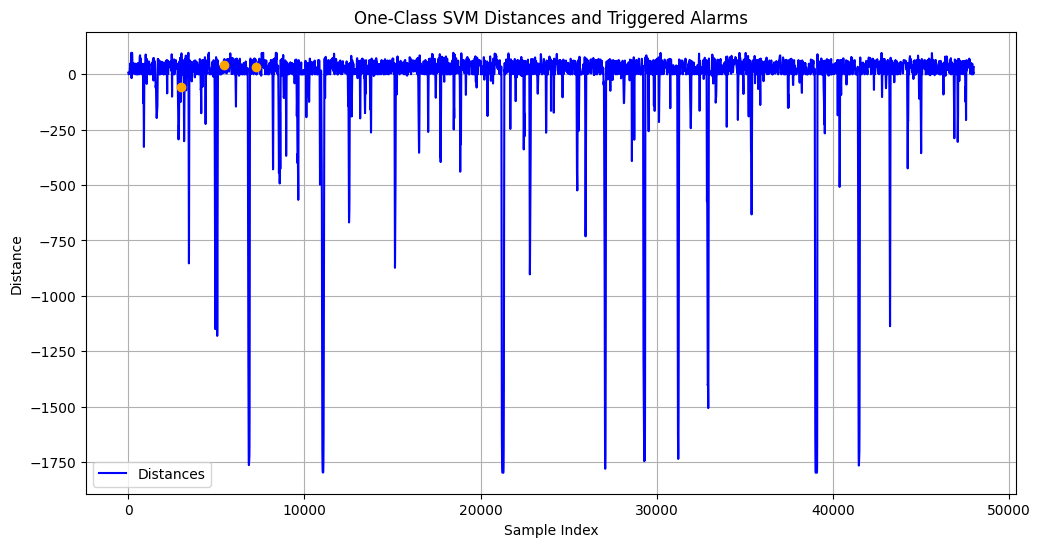

Alarm Indices: [2981, 5431, 7223]
Confidences: [0.5078516621330227, 0.507530802451896, 0.5118827402563382, 0.510517314805129, 0.5016668762110055, 0.5089155467572137]


In [75]:
def visualize_svm_results():
    # Plot distances and alarms
    plt.figure(figsize=(12, 6))
    plt.plot(distances, label="Distances", color="blue")
    plt.scatter(alarm_indices, [distances[i] for i in alarm_indices], 
            color="orange", zorder=5)
    plt.title("One-Class SVM Distances and Triggered Alarms")
    plt.xlabel("Sample Index")
    plt.ylabel("Distance")
    plt.legend()
    plt.grid()
    plt.show()

# Print alarms and confidences
    print("Alarm Indices:", alarm_indices)
    print("Confidences:", confidences)

visualize_svm_results()

In [45]:
def trigger_ocsvm_alarm(distances, threshold=-500):
    """
    Detect when 10 consecutive samples have distances below a specified threshold and trigger an alarm.
    No new alarms are triggered until the score becomes positive again.

    Parameters:
        distances (numpy.ndarray): Array of distances from the decision boundary (signed distances).
    
    Returns:
        alarm_indices (list): List of starting indices for alarms where the condition is met.
    """

    # Initialize variables
    alarm_indices = []
    consecutive_count = 0
    in_alarm_state = False  # Flag to track if we are in an alarm state
    
    # Iterate through the distances
    for i in range(len(distances)):
        if in_alarm_state:
            # Wait for a positive score to reset the alarm state
            if distances[i] > 0:
                in_alarm_state = False  # Reset the alarm state
            continue  # Skip further checks while in alarm state
        
        if distances[i] < threshold:
            consecutive_count += 1
            # If 10 consecutive samples meet the condition, trigger the alarm
            if consecutive_count == 10:
                # Record the starting index of the alarm
                alarm_indices.append(i - 9)  # Subtract 9 to get the starting index of the 10-sample sequence
                in_alarm_state = True  # Enter alarm state
        else:
            # Reset the consecutive count if condition is broken
            consecutive_count = 0

    return alarm_indices

In [39]:

# Plot distances and alarms
print(alarm_indices)

[3429, 4916, 5028, 6793, 9640, 10987]


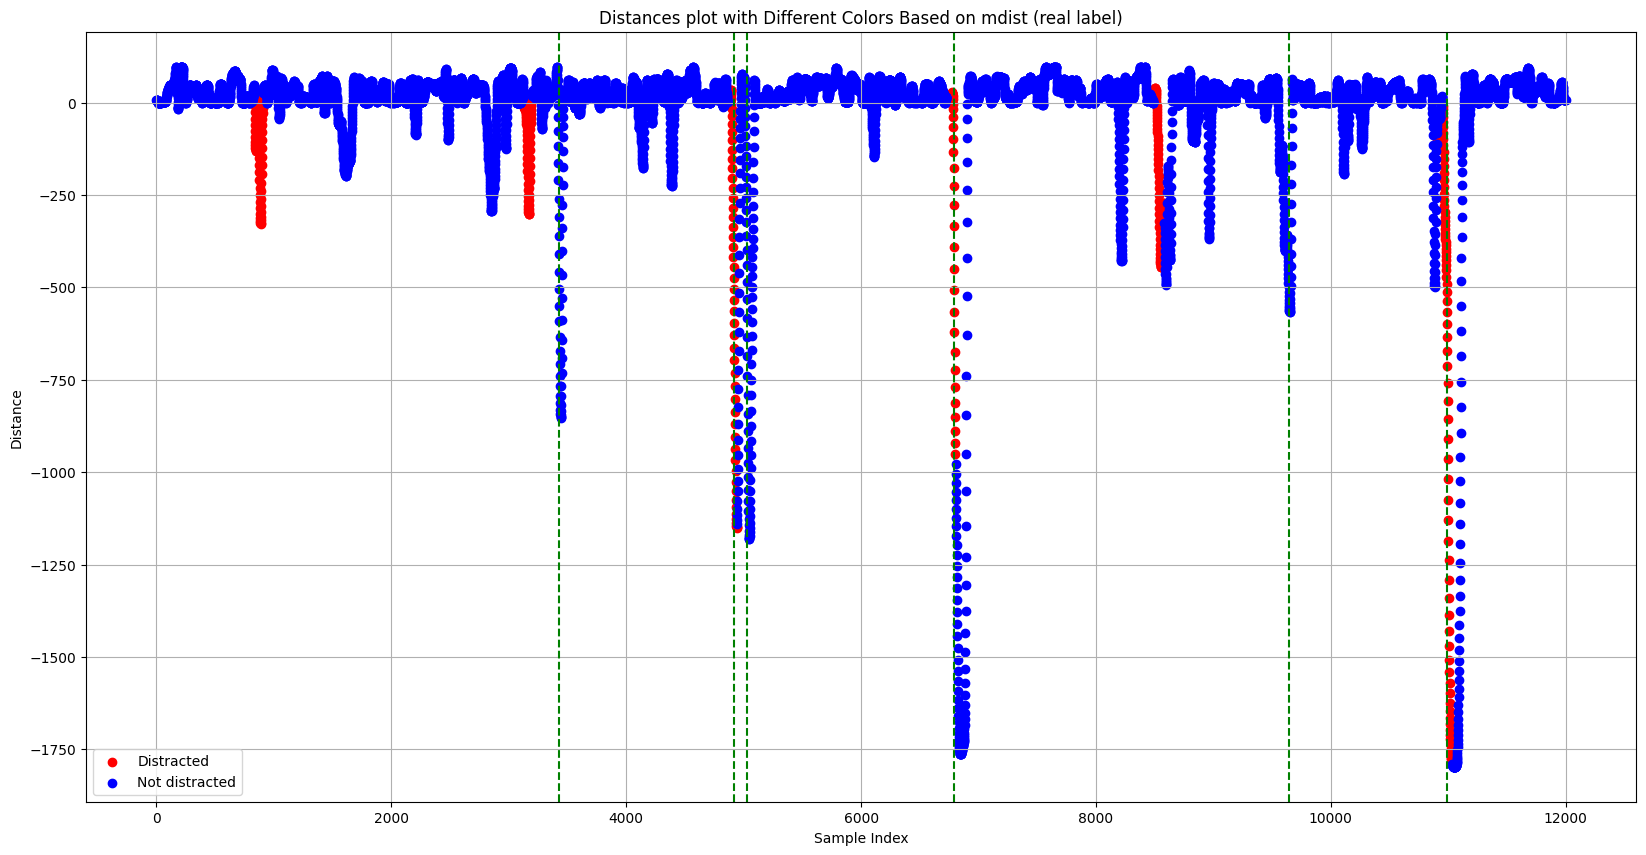

In [40]:
def plot_masked_signal(tc_test, distances):
    """
    Plots the error signal with different colors based on the real label.

    Parameters:
    - tc_test: The true labels array.
    - distances: The distances array.
    - run_idx: The index of the run to plot.
    - column_idx: The column index of tc_test to use for masking (default is 2).
    - run_length: The length of each run (default is 12000).
    """
   
    # Create a mask for tc_test == 1 and tc_test == 0
    mask_1 = tc_test == 1
    mask_0 = tc_test == 0

    # Plotting
    plt.figure(figsize=(20, 10))
    plt.scatter(np.arange(len(distances))[mask_1], distances[mask_1], color='red', label='Distracted')
    plt.scatter(np.arange(len(distances))[mask_0], distances[mask_0], color='blue', label='Not distracted')
    plt.grid()
    # Add labels and title
    plt.xlabel('Sample Index')
    plt.ylabel('Distance')
    plt.title('Distances plot with Different Colors Based on mdist (real label)')
    plt.legend()

# keep only the alarm indices which are smaller 
plot_masked_signal(tc_test_col, distances[:12000])
for i in alarm_indices:
    plt.axvline(x=i, color='green', linestyle='--')
plt.show()

In [41]:
def match_changepoints(true_changepoints, predicted_changepoints, tolerance=5):
    """
    Matches each predicted changepoint to a true changepoint within a tolerance window
    and computes the average time between matched pairs of true and predicted changepoints.

    Args:
        true_changepoints (list): List of true changepoint positions.
        predicted_changepoints (list): List of predicted changepoint positions.
        tolerance (int): Maximum allowable difference between true and predicted changepoints.

    Returns:
        dict: A dictionary with:
            - 'true_positives': Number of true changepoints that were matched.
            - 'pred_positives': Number of predicted changepoints that were matched.
            - 'total_true': Total number of true changepoints.
            - 'total_pred': Total number of predicted changepoints.
            - 'avg_detection_delay': Average time difference between matched true 
                                      and predicted changepoints (only for good samples).
    """
    # Ensure true_changepoints and predicted_changepoints are lists of individual points
    true_changepoints = list(true_changepoints)
    predicted_changepoints = list(predicted_changepoints)

    true_matched = set()  # Keeps track of matched true changepoints
    pred_matched = set()  # Keeps track of matched predicted changepoints
    detection_delays = []  # Stores time differences between matched pairs

    # Try to match each predicted changepoint to a true changepoint
    for pred_cp in predicted_changepoints:
        for true_cp in true_changepoints:
            # Check if the difference between pred_cp and true_cp is within tolerance
            if abs(pred_cp - true_cp) <= tolerance and true_cp not in true_matched:
                true_matched.add(true_cp)
                pred_matched.add(pred_cp)
                detection_delays.append(abs(pred_cp - true_cp))  # Record the delay
                break  # Move to next predicted changepoint after finding a match

    # True positives, predicted positives, and total true changepoints
    true_positives = len(true_matched)
    pred_positives = len(pred_matched)
    total_true = len(true_changepoints)
    total_pred = len(predicted_changepoints)

    # Compute average detection delay if there are matched pairs
    avg_detection_delay = sum(detection_delays) / len(detection_delays) if detection_delays else None

    return {
        'true_positives': true_positives,
        'pred_positives': pred_positives,
        'total_true': total_true,
        'total_pred': total_pred,
        'avg_detection_delay': avg_detection_delay
    }


In [42]:
alarm_indices = trigger_ocsvm_alarm(distances[36000:48000])
real_changepoints = compute_changepoints(tc_test)[3]

results = match_changepoints(real_changepoints, alarm_indices, tolerance=150)

print("results:", results)  

results: {'true_positives': 3, 'pred_positives': 3, 'total_true': 6, 'total_pred': 3, 'avg_detection_delay': 65.33333333333333}
